# 5. How to Log and Visualize Simulations

Here we explain how to take a log of simulation results and how to visualize it. 

In [1]:
%matplotlib inline
import math
from ecell4 import *

## 5.1. Logging Simulations with Observers

E-Cell4 provides special classes for logging, named `Observer`. `Observer` class is given when you call the `run` function of `Simulator`.

In [2]:
def create_simulator(f=gillespie.GillespieFactory()):
    m = NetworkModel()
    A, B, C = Species('A', '0.005', '1'), Species('B', '0.005', '1'), Species('C', '0.005', '1')
    m.add_reaction_rule(create_binding_reaction_rule(A, B, C, 0.01))
    m.add_reaction_rule(create_unbinding_reaction_rule(C, A, B, 0.3))
    w = f.create_world()
    w.bind_to(m)
    w.add_molecules(C, 60)
    sim = f.create_simulator(w)
    sim.initialize()
    return sim

One of most popular `Observer` is `FixedIntervalNumberObserver`, which logs the number of molecules with the given time interval. `FixedIntervalNumberObserver` requires an interval and a list of serials of `Species` for logging.

In [3]:
obs1 = FixedIntervalNumberObserver(0.1, ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)

`data` function of `FixedIntervalNumberObserver` returns the data logged.

In [4]:
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 1.0, 1.0, 59.0], [0.2, 3.0, 3.0, 57.0], [0.30000000000000004, 4.0, 4.0, 56.0], [0.4, 4.0, 4.0, 56.0], [0.5, 6.0, 6.0, 54.0], [0.6000000000000001, 7.0, 7.0, 53.0], [0.7000000000000001, 7.0, 7.0, 53.0], [0.8, 8.0, 8.0, 52.0], [0.9, 10.0, 10.0, 50.0], [1.0, 11.0, 11.0, 49.0]]


`targets()` returns a list of `Species`, which you specified as an argument of the constructor.

In [5]:
print([sp.serial() for sp in obs1.targets()])

[u'A', u'B', u'C']


`NumberObserver` logs the number of molecules after every steps when a reaction occurs. This observer is useful to log all reactions, but not available for `ode`.

In [6]:
obs1 = NumberObserver(['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.09134883902059292, 1.0, 1.0, 59.0], [0.15211314154020314, 2.0, 2.0, 58.0], [0.15496085140833654, 3.0, 3.0, 57.0], [0.24026333821518836, 4.0, 4.0, 56.0], [0.3753440719184117, 5.0, 5.0, 55.0], [0.47253244924070276, 6.0, 6.0, 54.0], [0.648213759108501, 7.0, 7.0, 53.0], [0.9936886892411085, 8.0, 8.0, 52.0], [0.996299466105839, 9.0, 9.0, 51.0], [1.0, 9.0, 9.0, 51.0]]


`TimingNumberObserver` allows you to give the times for logging as an argument of its constructor.

In [7]:
obs1 = TimingNumberObserver([0.0, 0.1, 0.2, 0.5, 1.0], ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 1.0, 1.0, 59.0], [0.2, 3.0, 3.0, 57.0], [0.5, 5.0, 5.0, 55.0], [1.0, 9.0, 9.0, 51.0]]


`run` function accepts multile `Observer`s at once.

In [8]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(1.0, [obs1, obs2])
print(obs1.data())
print(obs2.data())

[[0.0, 60.0], [0.09134883902059292, 59.0], [0.10280429475438999, 58.0], [0.1868839821517399, 57.0], [0.29470071670438486, 56.0], [0.40249994199783157, 55.0], [0.49241465584673916, 54.0], [0.5421575022652043, 53.0], [0.7280549037366937, 52.0], [0.8389034469795151, 51.0], [0.8575175554958695, 50.0], [0.9305592737152916, 49.0], [1.0, 49.0]]
[[0.0, 0.0, 0.0], [0.1, 1.0, 1.0], [0.2, 3.0, 3.0], [0.30000000000000004, 4.0, 4.0], [0.4, 4.0, 4.0], [0.5, 6.0, 6.0], [0.6000000000000001, 7.0, 7.0], [0.7000000000000001, 7.0, 7.0], [0.8, 8.0, 8.0], [0.9, 10.0, 10.0], [1.0, 11.0, 11.0]]


`FixedIntervalHDF5Observedr` logs the whole data in a `World` to an output file with the fixed interval. Its second argument is a prefix for output filenames. `filename()` returns the name of a file scheduled to be saved next. At most one format string like `%02d` is allowed to use a step count in the file name. When you do not use the format string, it overwrites the latest data to the file.

In [9]:
obs1 = FixedIntervalHDF5Observer(0.2, 'data/test%02d.h5')
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

data/test00.h5
data/test06.h5


In [10]:
w = load_world('data/test05.h5')
print(w.t(), w.num_molecules(Species('C')))

(1.0, 52)


The usage of `FixedIntervalCSVObserver` is almost same with that of `FixedIntervalHDF5Observer`. It saves positions (x, y, z) of particles with the radius (r) and serial number of `Species` (sid) to a CSV file.

In [11]:
obs1 = FixedIntervalCSVObserver(0.2, "data/test%02d.csv")
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

data/test00.csv
data/test06.csv


Here is the first 10 lines in the output CSV file.

In [12]:
print(''.join(open("data/test05.csv").readlines()[: 10]))

x,y,z,r,sid
0.97039167117327452,0.036110264481976628,0.34472030657343566,0,0
0.97243690234608948,0.4990095947869122,0.82824724307283759,0,0
0.38704646099358797,0.80065731634385884,0.046656291699036956,0,0
0.80162350414320827,0.32450902624987066,0.39120621001347899,0,0
0.89642994711175561,0.20224382053129375,0.23424044856801629,0,0
0.48671071138232946,0.41283330088481307,0.92735499679110944,0,0
0.70192972500808537,0.36502269608899951,0.33350185956805944,0,0
0.71532290382310748,0.29772869357839227,0.98406919441185892,0,0
0.15586451650597155,0.75952479219995439,0.4297296185977757,0,0



For particle simulations, E-Cell4 also provides `Observer` to trace a trajectory of a molecule, named `FixedIntervalTrajectoryObserver`. When no `ParticleID` is specified, it logs all the trajectories. Once some `ParticleID` is lost for the reaction during a simulation, it just stop to trace the particle any more.

In [13]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalTrajectoryObserver(0.01)
sim.run(0.1, obs1)

In [14]:
print([tuple(pos) for pos in obs1.data()[0]])

[(0.8573214099741124, 0.7303480905248766, 0.20500000000000002), (0.9308061022576077, 0.7014805770653953, 0.325), (1.1757550765359255, 0.5542562584220407, 0.42), (1.1594251449173711, 0.6148780366869514, 0.535), (1.126765281680262, 0.7707626093681504, 0.805), (1.2410748030101437, 0.7447818472546173, 1.0), (1.1349302474895393, 0.48786097746523377, 0.855), (1.126765281680262, 0.45899346400575247, 1.0050000000000001), (1.0369506577782122, 0.7216878364870323, 1.1), (1.0451156235874894, 0.536935750346352, 0.98), (0.7593418202627853, 0.3233161507461904, 0.92)]


Generally, `World` assumes a periodic boundary for each plane. To avoid the big jump of a particle at the edge due to the boundary condition, `FixedIntervalTrajectoryObserver` tries to keep the shift of positions. Thus, the positions stored in the `Observer` are not necessarily limited in the cuboid given for the `World`. To track the diffusion over the boundary condition accurately, the step interval for logging must be small enough. Of course, you can disable this option. See `help(FixedIntervalTrajectoryObserver)`.

## 5.2. Visualization of Data Logged

In this section, we explain the visualization tools for data logged by `Observer`.

Firstly, for time course data, `viz.plot_number_observer` plots the data provided by `NumberObserver`, `FixedIntervalNumberObserver` and `TimingNumberObserver`. For the detailed usage of `viz.plot_number_observer`, see `help(viz.plot_number_observer)`.

In [15]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(10.0, [obs1, obs2])

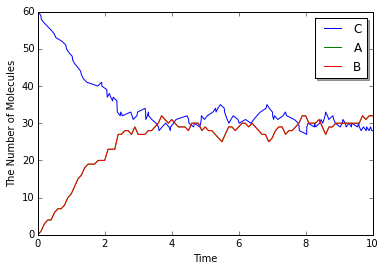

In [16]:
viz.plot_number_observer(obs1, obs2)

You can set the style for plotting, and even add an arbitrary function to plot.

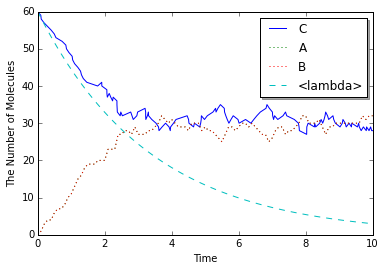

In [17]:
viz.plot_number_observer(obs1, '-', obs2, ':', lambda t: 60 * math.exp(-0.3 * t), '--')

Plotting in the phase plane is also available by specifing the x-axis and y-axis.

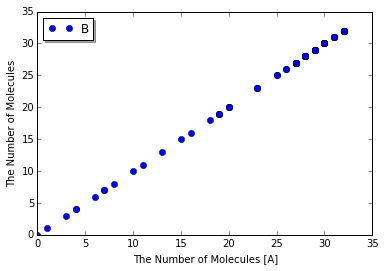

In [18]:
viz.plot_number_observer(obs2, 'o', x='A', y='B')

For spatial simulations, to visualize the state of `World`, `viz.plot_world` is available. This function plots the points of particles in three-dimensional volume in the interactive way. You can save the image by clicking a right button on the drawing region.

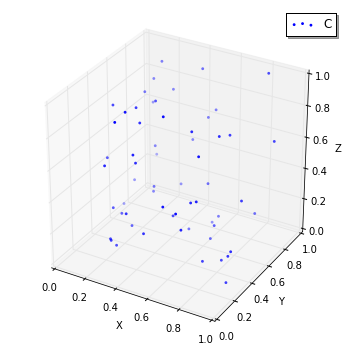

In [19]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
# viz.plot_world(sim.world())
viz.plot_world(sim.world(), interactive=False)

You can also make a movie from a series of HDF5 files, given as a `FixedIntervalHDF5Observer`. NOTE: `viz.plot_movie` requires an extra library, `ffmpeg`, when `interactive=False`.

In [20]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalHDF5Observer(0.02, 'data/test%02d.h5')
sim.run(1.0, obs1)
viz.plot_movie(obs1)

Start generating species_list ...
Start preparing mplot3d ...
Start making animation ...
Start generating a movie ...


Finally, corresponding to `FixedIntervalTrajectoryObserver`, `viz.plot_trajectory` provides a visualization of particle trajectories.

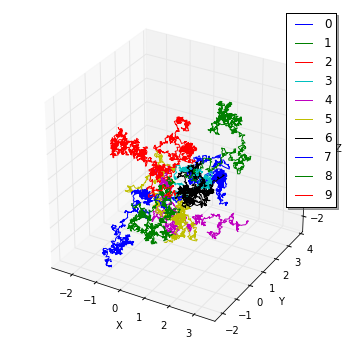

In [21]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalTrajectoryObserver(1e-3)
sim.run(1, obs1)
# viz.plot_trajectory(obs1)
viz.plot_trajectory(obs1, interactive=False)